## load necessary libraries

In [1]:
# load necessary libraries for network anaylysis
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os as os
import powerlaw
import mygene
import matplotlib.patches as mpatches

import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.preprocessing import MinMaxScaler

## load the edgelist of turquoise module

In [2]:
# load the data tab separated txtile

file_path = r"/home/vishnu/Documents/IGF2BP2_project/gse197726_data/wgcna_and_other_data_from_kangto/wgcna_output_salmon/wgcna_binarized_implementation_v2/edge_list_v2/turqoise/unique_turqoise_edgelist_v2.tsv"

data = pd.read_csv(file_path,sep='\t')

#print the head
print(data.head())

                gene1               gene2  correlation    module1    module2
0  ENSMUSG00000000056  ENSMUSG00000000142     0.004410  turquoise  turquoise
1  ENSMUSG00000000056  ENSMUSG00000000296     0.018844  turquoise  turquoise
2  ENSMUSG00000000056  ENSMUSG00000000305     0.015351  turquoise  turquoise
3  ENSMUSG00000000056  ENSMUSG00000000751     0.013524  turquoise  turquoise
4  ENSMUSG00000000056  ENSMUSG00000000915     0.048755  turquoise  turquoise


## consider edges with correlation values greater than 0.1

In [3]:
# Count edges before filtering
num_edges_before = len(data)
print(f"Number of edges before filtering: {num_edges_before}")


# Filter edges where correlation is greater than 0.1
filtered_df = data[data['correlation'] > 0.1]

# Count edges after filtering
num_edges_after = len(filtered_df)
print(f"Number of edges after filtering: {num_edges_after}")

# Print the head of the filtered DataFrame
print("Head of the filtered data:")
print(filtered_df.head())

Number of edges before filtering: 208981
Number of edges after filtering: 3398
Head of the filtered data:
                  gene1               gene2  correlation    module1    module2
124  ENSMUSG00000000056  ENSMUSG00000021775     0.143522  turquoise  turquoise
241  ENSMUSG00000000056  ENSMUSG00000027559     0.106918  turquoise  turquoise
404  ENSMUSG00000000056  ENSMUSG00000037493     0.109828  turquoise  turquoise
406  ENSMUSG00000000056  ENSMUSG00000037685     0.134360  turquoise  turquoise
465  ENSMUSG00000000056  ENSMUSG00000044951     0.110818  turquoise  turquoise


## create a network object

In [6]:

# Create graph
G = nx.Graph()
for _, row in filtered_df.iterrows():
    G.add_edge(row['gene1'], row['gene2'], weight=row['correlation'])

# Step 1: Convert all Ensembl IDs to gene symbols
all_nodes = list(G.nodes())
mg = mygene.MyGeneInfo()
query_result = mg.querymany(all_nodes, scopes='ensembl.gene', fields='symbol', species='mouse')

# Step 2: Build mapping dictionary
id_to_symbol = {item['query']: item.get('symbol', item['query']) for item in query_result}

# Step 3: Relabel nodes in the main graph
nx.relabel_nodes(G, id_to_symbol, copy=False)

# Step 4: Compute degree in the renamed graph
degree_dict = dict(G.degree())
degree_df = pd.DataFrame(degree_dict.items(), columns=['Node', 'Degree'])
degree_df = degree_df.sort_values(by='Degree', ascending=False)

# Step 5: Save all and top 25
base_path = "/home/vishnu/Documents/IGF2BP2_project/gse197726_data/network_analysis_for_v2_files/turquoise/clean_files"
degree_df.to_csv(os.path.join(base_path, "all_nodes_by_degree.csv"), index=False, sep='\t', encoding='utf-8')
print("All nodes saved to all_nodes_by_degree.csv")

top_25_df = degree_df.head(25)
top_25_df.to_csv(os.path.join(base_path, "top_25_nodes_by_degree.csv"), index=False, sep='\t', encoding='utf-8')
print("Top 25 nodes saved to top_25_nodes_by_degree.csv")


# Step 6: Extract subgraph
top_25_nodes = list(top_25_df['Node'])
subgraph = G.subgraph(top_25_nodes).copy()


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


All nodes saved to all_nodes_by_degree.csv
Top 25 nodes saved to top_25_nodes_by_degree.csv


Normalized degrees: [0.0969163  0.04405286 0.33039648 0.27753304 0.06167401 0.19823789
 0.0969163  0.34361233 0.69603524 0.01762115 0.19823789 0.04845815
 0.12334802 0.02202643 0.13656388 0.27312775 0.05286344 0.
 0.59911894 0.30396476 0.42290749 0.02643172 0.60352423 1.
 0.36123348]


/tmp/ipykernel_15640/2474845638.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Wistia')


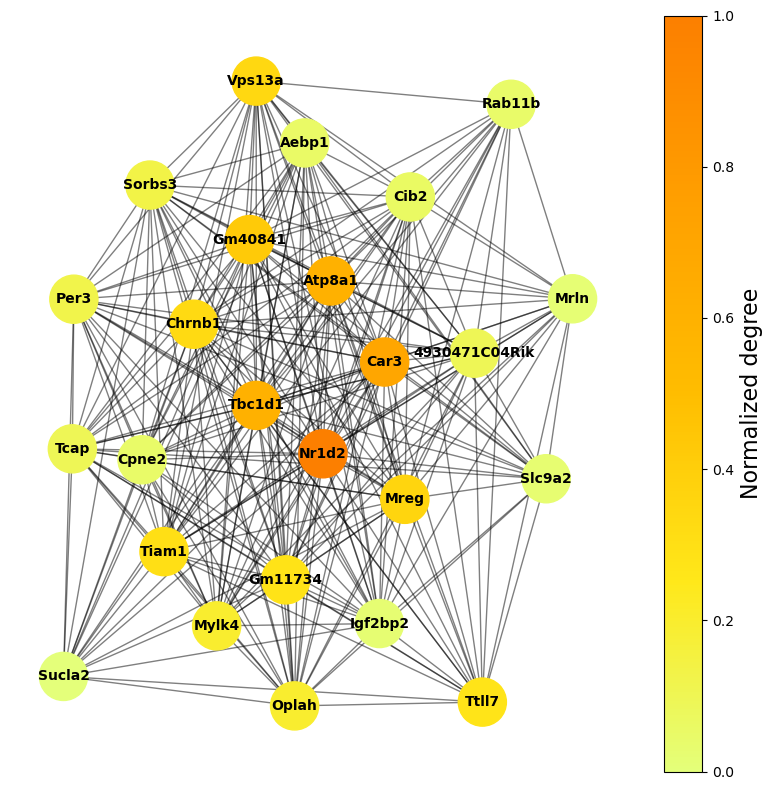

In [22]:
# Step 7: Get degrees from main graph and align with subgraph node order
main_degrees = dict(G.degree(top_25_nodes))
ordered_degrees = [main_degrees[node] for node in subgraph.nodes()]  # maintain correct order

# Normalize degrees to 0-1
scaler = MinMaxScaler()
normalized_degrees = scaler.fit_transform(np.array(ordered_degrees).reshape(-1, 1)).flatten()
print("Normalized degrees:", normalized_degrees)

# Color and size using normalized values
cmap = cm.get_cmap('Wistia')
node_colors = [cmap(value) for value in normalized_degrees]
# node_sizes = [value * 7500 for value in normalized_degrees]  # base size + scaling

# Step 8: Plot
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(subgraph)
nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=1200)
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold')
# plt.title("Top 25 Genes by Degree (Gene Symbols, Normalized)", fontsize=16)
plt.axis("off")

# Add colorbar (based on original degrees)
norm = colors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ax = plt.gca()   # get current axes
cbar = plt.colorbar(sm, ax=ax)

cbar.set_label('Normalized degree', fontsize=16)

plt.tight_layout()

# Save plots
plt.savefig("/home/vishnu/Documents/IGF2BP2_project/gse197726_data/network_analysis_for_v2_files/turquoise/clean_files/top_25_genes_by_degree_normalized.tiff", dpi=300, bbox_inches='tight')
plt.savefig("/home/vishnu/Documents/IGF2BP2_project/gse197726_data/network_analysis_for_v2_files/turquoise/clean_files/top_25_genes_by_degree_normalized.svg", dpi=300, bbox_inches='tight', transparent=True)
plt.savefig("/home/vishnu/Documents/IGF2BP2_project/gse197726_data/network_analysis_for_v2_files/turquoise/clean_files/top_25_genes_by_degree_normalized.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()


## extract the first neighbours

In [ ]:
# Step 1: Extract first neighbors of top 25 genes
neighbor_dict = {}

for node in top_25_nodes:
    neighbors = list(G.neighbors(node))
    neighbor_dict[node] = neighbors

# Step 2: Convert to DataFrame (column-wise structure)
max_length = max(len(neighbors) for neighbors in neighbor_dict.values())
df_neighbors = pd.DataFrame({k: v + [''] * (max_length - len(v)) for k, v in neighbor_dict.items()})

# Step 3: Save to CSV and Excel
csv_path = "/home/vishnu/transcriptomics_for_thesis_with_shriyansh/network_analysis_for_v2_files/turquoise/degree/neighbours_of_top_25_genes_by_degree/top_25_gene_neighbors.csv"
xlsx_path = "/home/vishnu/transcriptomics_for_thesis_with_shriyansh/network_analysis_for_v2_files/turquoise/degree/neighbours_of_top_25_genes_by_degree/top_25_gene_neighbors.xlsx"

df_neighbors.to_csv(csv_path, index=False)
df_neighbors.to_excel(xlsx_path, index=False)

In [ ]:
from collections import Counter

# Step 1: Extract neighbors
neighbor_dict = {node: set(G.neighbors(node)) for node in top_25_nodes}

# Step 2: Flatten and count all neighbors
all_neighbors_flat = [neighbor for neighbors in neighbor_dict.values() for neighbor in neighbors]
neighbor_counts = Counter(all_neighbors_flat)

# Step 3: Common neighbors — appear in all 25 sets
common_neighbors = [node for node, count in neighbor_counts.items() if count == len(top_25_nodes)]

# Step 4: Unique neighbors — appear in only 1 set
unique_neighbors = [node for node, count in neighbor_counts.items() if count == 1]

# Step 5: Save common and unique neighbors
df_common = pd.DataFrame({'common_neighbors': common_neighbors})
df_unique = pd.DataFrame({'unique_neighbors': unique_neighbors})

# File paths
common_path_csv = "/home/vishnu/transcriptomics_for_thesis_with_shriyansh/network_analysis_for_v2_files/turquoise/degree/neighbours_of_top_25_genes_by_degree/common_neighbors.csv"
unique_path_csv = "/home/vishnu/transcriptomics_for_thesis_with_shriyansh/network_analysis_for_v2_files/turquoise/degree/neighbours_of_top_25_genes_by_degree/unique_neighbors.csv"

common_path_xlsx = common_path_csv.replace(".csv", ".xlsx")
unique_path_xlsx = unique_path_csv.replace(".csv", ".xlsx")

# Save
df_common.to_csv(common_path_csv, index=False)
df_common.to_excel(common_path_xlsx, index=False)

df_unique.to_csv(unique_path_csv, index=False)
df_unique.to_excel(unique_path_xlsx, index=False)

In [ ]:
print(top_25_df.head())

        Node  Degree
365    Nr1d2     301
364     Car3     232
362   Atp8a1     211
351   Tbc1d1     210
359  Gm40841     170


## test for power-law (not required)

Calculating best minimal value for power law fit
Power-law exponent (alpha): 2.2526960719536584
Minimum value for power-law behavior (xmin): 11.0
Log-likelihood ratio (R) comparing power-law vs. exponential: 46.77972438648722, p-value: 1.327169253594837e-07
Log-likelihood ratio (R) comparing power-law vs. lognormal: -0.014638807241521778, p-value: 0.8858682065778599


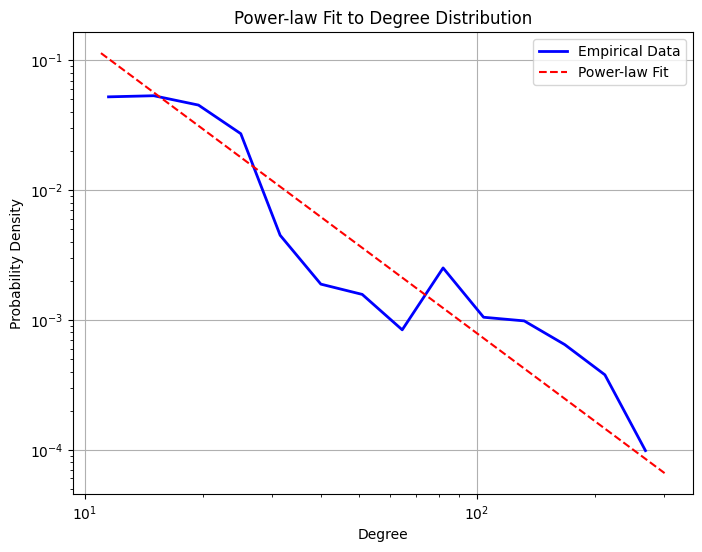

In [ ]:
# Compute node degrees
degree_sequence = [deg for _, deg in G.degree()]

# Fit power-law distribution
fit = powerlaw.Fit(degree_sequence)

# Print power-law fit parameters
print(f"Power-law exponent (alpha): {fit.power_law.alpha}")
print(f"Minimum value for power-law behavior (xmin): {fit.power_law.xmin}")

# Compare power-law with exponential and lognormal distributions
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Log-likelihood ratio (R) comparing power-law vs. exponential: {R}, p-value: {p}")

R_ln, p_ln = fit.distribution_compare('power_law', 'lognormal')
print(f"Log-likelihood ratio (R) comparing power-law vs. lognormal: {R_ln}, p-value: {p_ln}")

# Plot degree distribution with power-law fit
plt.figure(figsize=(8, 6))
fit.plot_pdf(label="Empirical Data", color='blue', linewidth=2)
fit.power_law.plot_pdf(label="Power-law Fit", color='red', linestyle="--")
plt.xlabel("Degree")
plt.ylabel("Probability Density")
plt.title("Power-law Fit to Degree Distribution")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
base_folder= "/home/vishnu/transcriptomics_for_thesis_with_shriyansh/network_analysis_for_v2_files/turquoise"

## compute the betweeness centrality

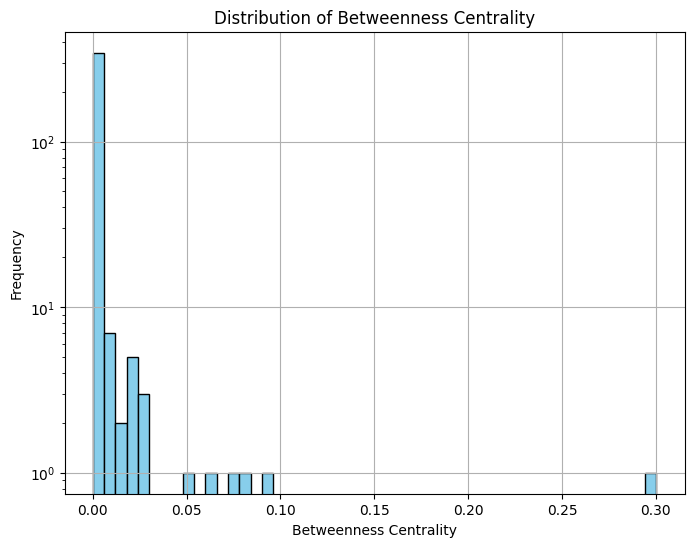

Betweenness centrality analysis completed and files saved.


In [ ]:
# Define the folder path
output_folder = "/home/vishnu/transcriptomics_for_thesis_with_shriyansh/network_analysis_for_v2_files/betweenness"

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Compute betweenness centrality
betweenness = nx.betweenness_centrality(G)

# Convert to DataFrame
betweenness_df = pd.DataFrame(betweenness.items(), columns=['Node', 'Betweenness'])
betweenness_df = betweenness_df.sort_values(by='Betweenness', ascending=False)

# Save full betweenness centrality values
betweenness_df.to_csv(os.path.join(output_folder, "betweenness_centrality.csv"), index=False,sep='\t',encoding='utf-8')

# Save top 25 nodes by betweenness
top_25_df = betweenness_df.head(25)
top_25_df.to_csv(os.path.join(output_folder, "top_25_betweenness.csv"), index=False,sep='\t',encoding='utf-8')

# Plot betweenness centrality distribution
plt.figure(figsize=(8, 6))
plt.hist(betweenness_df['Betweenness'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")
plt.title("Distribution of Betweenness Centrality")
plt.yscale("log")  # Log scale to handle skewed distribution
plt.grid()

# Save plot
plt.savefig(os.path.join(output_folder, "betweenness_distribution.png"))
plt.show()

print("Betweenness centrality analysis completed and files saved.")

## compute eigenvector centrality

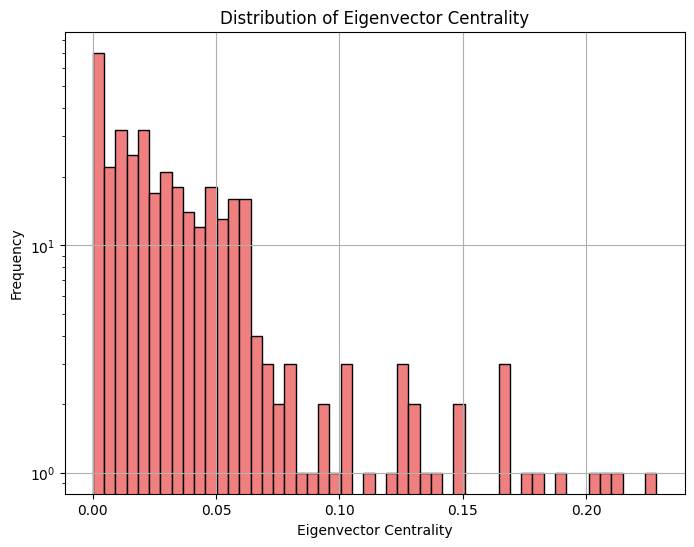

Eigenvector centrality analysis completed. Files saved in: /home/vishnu/transcriptomics_for_thesis_with_shriyansh/network_analysis_for_v2_files/turquoise/eigenvector


In [ ]:
# Create subfolder for eigenvector centrality
eigenvector_folder = os.path.join(base_folder, "eigenvector")
os.makedirs(eigenvector_folder, exist_ok=True)


# Compute Eigenvector Centrality
eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

# Convert to DataFrame
eigenvector_df = pd.DataFrame(eigenvector.items(), columns=['Node', 'Eigenvector Centrality'])
eigenvector_df = eigenvector_df.sort_values(by='Eigenvector Centrality', ascending=False)

# Save full Eigenvector Centrality values
eigenvector_df.to_csv(os.path.join(eigenvector_folder, "eigenvector_centrality.csv"), index=False,sep='\t',encoding='utf-8')

# Save top 25 nodes by Eigenvector Centrality
top_25_df = eigenvector_df.head(25)
top_25_df.to_csv(os.path.join(eigenvector_folder, "top_25_eigenvector.csv"), index=False,sep='\t',encoding='utf-8')

# Plot Eigenvector Centrality distribution
plt.figure(figsize=(8, 6))
plt.hist(eigenvector_df['Eigenvector Centrality'], bins=50, color='lightcoral', edgecolor='black')
plt.xlabel("Eigenvector Centrality")
plt.ylabel("Frequency")
plt.title("Distribution of Eigenvector Centrality")
plt.yscale("log")  # Log scale for better visualization
plt.grid()

# Save plot
plt.savefig(os.path.join(eigenvector_folder, "eigenvector_distribution.png"))
plt.show()

print("Eigenvector centrality analysis completed. Files saved in:", eigenvector_folder)


In [ ]:
#print the len of number of nodes
num_nodes = len(G.nodes())
print(f"Number of nodes in the graph: {num_nodes}")

Number of nodes in the graph: 367


## community analysis using louvain algorithm


/tmp/ipykernel_732287/905587526.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_communities)


Community information saved to: /home/vishnu/transcriptomics_for_thesis_with_shriyansh/network_analysis_for_v2_files/turquoise/community/louvain_communities.csv


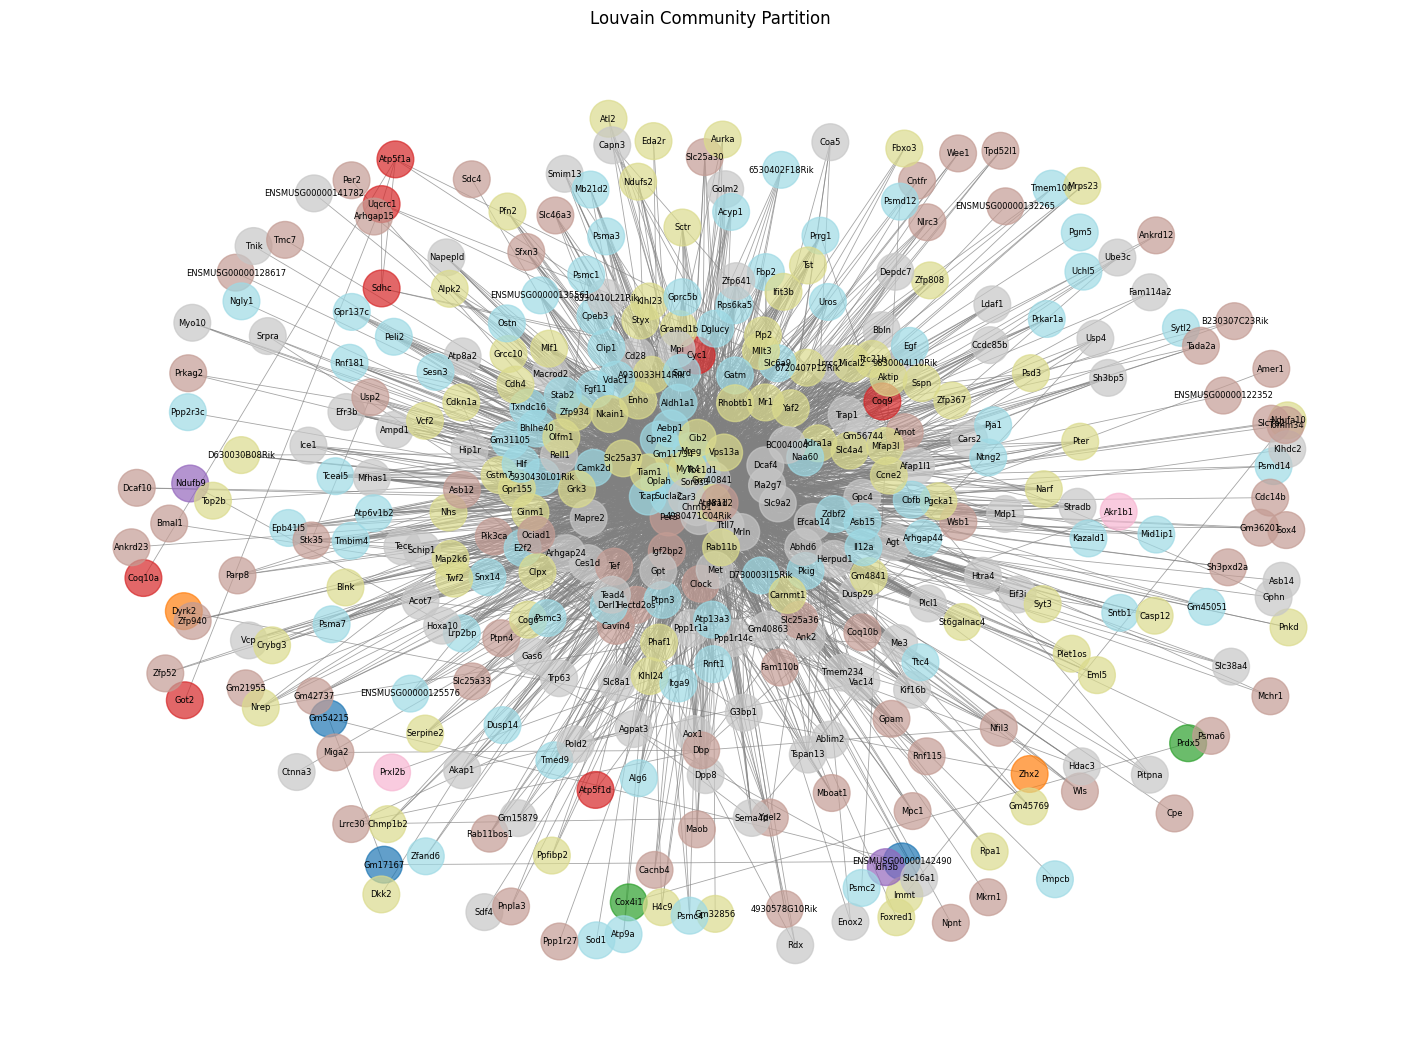

Community plot saved to: /home/vishnu/transcriptomics_for_thesis_with_shriyansh/network_analysis_for_v2_files/turquoise/community/louvain_community_plot.svg


In [ ]:
# Create subfolder for community analysis
community_folder = os.path.join(base_folder, "community")
os.makedirs(community_folder, exist_ok=True)

# Apply Louvain community detection
communities = nx.community.louvain_communities(G, weight='weight',resolution=1, seed=42)

# Create a mapping from node to community index
community_map = {}
for idx, community in enumerate(communities):
    for node in community:
        community_map[node] = idx

# Generate unique colors for each community
num_communities = len(communities)
colors = plt.cm.get_cmap("tab20", num_communities)
community_colors = {i: colors(i) for i in range(num_communities)}

# Create a dictionary with community number as column names
community_dict = {}
for idx, community in enumerate(communities):
    column_name = f"Community {idx+1}"
    community_dict[column_name] = list(community)

# Convert to DataFrame (transposing to align nodes under each column)
community_df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in community_dict.items()]))

# Save to CSV
csv_path = os.path.join(community_folder, "louvain_communities.csv")
community_df.to_csv(csv_path, index=False, sep='\t', encoding='utf-8')

print(f"Community information saved to: {csv_path}")

### **🔹 Plotting the Communities**
plt.figure(figsize=(14, 10))  # Increase the figure size
pos = nx.spring_layout(G, seed=42, k=0.3)  # Adjust k for more spread out nodes (default k=0.1)


# Assign colors to nodes based on community membership
node_colors = [community_colors[community_map[node]] for node in G.nodes()]

# Draw the network with assigned colors
nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.tab20, 
        node_size=700, edge_color='gray', alpha=0.7, width=0.6)  # Adjust node size, alpha, and edge width

# Add node labels
nx.draw_networkx_labels(G, pos, font_size=6, font_color='black')

plt.title("Louvain Community Partition")
svg_path = os.path.join(community_folder, "louvain_community_plot.svg")
plt.savefig(svg_path, format="svg", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

print(f"Community plot saved to: {svg_path}")


In [ ]:
# Get top 25 hub genes by degree
degree_dict = dict(G.degree())
top_25_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:25]

# Map each top hub gene to its community
top25_community_info = {
    "Gene": top_25_nodes,
    "Degree": [degree_dict[node] for node in top_25_nodes],
    "Community": [community_map[node] + 1 for node in top_25_nodes]  # +1 for human-friendly numbering
}

# Create DataFrame and save
top25_df = pd.DataFrame(top25_community_info)
top25_csv_path = os.path.join(community_folder, "top25_hub_genes_community.csv")
top25_df.to_csv(top25_csv_path, index=False,sep='\t', encoding='utf-8')

# Print summary
print("\nTop 25 hub genes and their communities:")
print(top25_df)

print(f"\nTop 25 hub gene community info saved to: {top25_csv_path}")


Top 25 hub genes and their communities:
             Gene  Degree  Community
0           Nr1d2     301          6
1            Car3     232          8
2          Atp8a1     211          9
3          Tbc1d1     210         10
4         Gm40841     170          8
5            Mreg     156         10
6          Vps13a     152          9
7          Chrnb1     149          8
8           Tiam1     143          9
9         Gm11734     137          9
10          Ttll7     136          8
11          Oplah     119         10
12          Mylk4     119          9
13         Sorbs3     105         10
14           Per3     102          6
15           Tcap      96         10
16  4930471C04Rik      96          8
17           Cib2      88          9
18          Aebp1      86         10
19          Cpne2      85         10
20         Rab11b      84          9
21         Slc9a2      80          8
22        Igf2bp2      79          6
23           Mrln      78          8
24         Sucla2      74         